In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import muse.supplier as spr
import muse.processor as pcr
import muse.model2 as mdl
import muse.trainer as trn
import muse.visualizer as vis

import warnings
warnings.filterwarnings("ignore")

In [2]:
### ===== Hyperparameters ===== ###

mdl_name = 'ae'
instrument = 'Piano'
filepath = "./../input/haydn/"
song_len = 200*1
stride = 200
epochs = 1000
learning_rate = 0.001
device = trn.get_device()

In [3]:
def get_map_offset(instru2corpus, instrument):
    Corpus = []
    for num in range(len(instru2corpus[instrument])):
        song = np.array([float(off[1]) for off in np.array(instru2corpus[instrument][num])])
        song = song[1:]-song[:-1]
        Corpus += list([round(off,2) for off in song])+[1]
    Corpus = list(set(Corpus))
    
    fmap, rmap = {}, {}
    for idx, key in enumerate(sorted(Corpus)):
        fmap[key] = idx
        rmap[idx] = key
    return Corpus, fmap, rmap

In [4]:
### ===== Data Preprocessing ===== ###

seed_load = np.random.randint(0,999999999)
seed_load = 592643464 # set to seed that works

all_midis, filenames = pcr.get_midis(filepath) # load all .midi files
Corpus, instru2corpus = pcr.extract_notes_batch(all_midis) # extract all notes and sort by instrument
Corpus = pcr.remove_rare(Corpus, 0)[0] # remove notes that occur for less than $thre$ times
Corpus, fmap, rmap = pcr.get_map(Corpus) # get forward-map and reverse-map from corpus
instru2corpus = pcr.remove_short(instru2corpus) # remove songs that are too short

X_train_melody, X_val_melody, X_train_offset, X_val_offset = pcr.train_test_split(instru2corpus, instrument, fmap, song_len, stride,\
                                                                                  seed=seed_load, process='center')
X_train_melody, X_val_melody = pcr.batchify(X_train_melody), pcr.batchify(X_val_melody) # reshape and turn into tensor
X_train_offset, X_val_offset = pcr.batchify(X_train_offset), pcr.batchify(X_val_offset) # reshape and turn into tensor

classes = len(set(Corpus)) # get number of unique keys

In [28]:
from torch.distributions.normal import Normal

class cnn_encoder(nn.Module):
    def __init__(self, inp_channel):
        super(cnn_encoder, self).__init__()
        
        self.conv1 = nn.Conv1d(inp_channel, 16, 21, 1, 0)
        self.conv2 = nn.Conv1d(16, 4, 11, 1, 0)
        self.pool = nn.MaxPool1d(2,2)
        self.relu = nn.ReLU()

    def forward(self, I):
        h = self.pool(self.relu(self.conv1(I)))
        h = self.pool(self.relu(self.conv2(h)))
        return h
    
class cnn_decoder(nn.Module):
    def __init__(self, inp_channel, mult):
        super(cnn_decoder, self).__init__()
        
        self.tconv1 = nn.ConvTranspose1d(4, 16, 11, 1, 0)
        self.tconv2 = nn.ConvTranspose1d(16, inp_channel, 31, 1, 0)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(80, 200*mult)
        
    def forward(self, I):
        h = self.tconv2(self.relu(self.tconv1(I)))
        return self.linear(h.squeeze())
    
class cnn_autoencoder(nn.Module):
    def __init__(self, inp_channel, mult, classes, std=1.0):
        super(cnn_autoencoder, self).__init__()
        self.encoder = cnn_encoder(inp_channel)
        self.decoder = cnn_decoder(inp_channel, mult)
        self.mult = mult
        self.classes = classes
        self.std = std
        
    def get_prob(self, y):
        mu = y.squeeze()
        norm = Normal(mu, torch.tensor([self.std]))
        x = torch.arange(self.classes).expand(200*self.mult, self.classes)
        x = torch.transpose(x, 0, 1)
        prob = norm.log_prob(x) 
        prob = torch.transpose(prob, 0, 1)
        return prob
        
    def forward(self, I):
        z = self.encoder(I)
        y = self.decoder(z)
        prob = self.get_prob(y)
        return y, prob

In [27]:
### ===== Training Loop ===== ###

def train_model(model, device, mdl_name,
                train_loader, val_loader, 
                lr, seeds, epochs, 
                eepoch=10, epoch_start=0,
                lda0=1, lda1=1,
                train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                stdlog=[],
                save=True, load=False):
    
    # get loss function 
    criterion1 = nn.MSELoss()
    criterion2 = nn.CrossEntropyLoss()
    
    # get optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # load model
    if load:
        model, train_losses, val_losses, train_acc, val_acc, epoch_start, seeds = trn.load_model(mdl_name, model, device)
        
    # set parameters
    if type(lda0) != np.ndarray: lda0 = np.ones(epochs)*lda0
    if type(lda1) != np.ndarray: lda1 = np.ones(epochs)*lda1

    # training loop
    for epoch in range(epoch_start, epoch_start+epochs):
        
        # set std
        e = epoch-epoch_start
        if stdlog != []:
            model.std = stdlog[e]

        # train model
        model.train()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(train_loader):
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            recons, prob = model(batch_data)
            
            # calculate loss
            if lda1.all() != 0:
                l = lda0[e]*criterion1(recons, batch_data) + lda1[e]*criterion2(prob, batch_data.squeeze().long())
            else:
                l = lda0[e]*criterion1(recons, batch_data)
            l.backward()
            optimizer.step()
            batch_losses.append(l.item())
            
        train_losses.append(np.mean(batch_losses))
        train_acc.append(trn.accuracy(recons.view(-1), batch_data.view(-1)))

        # validate model
        model.eval()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(val_loader):
            batch_data = batch_data.to(device)
            recons, prob = model(batch_data)
            
            # calculate loss
            if lda1.all() != 0:
                l = lda0[e]*criterion1(recons, batch_data) + lda1[e]*criterion2(prob, batch_data.squeeze().long())
            else:
                l = lda0[e]*criterion1(recons, batch_data)
            batch_losses.append(l.item())
            
        val_losses.append(np.mean(batch_losses))
        val_acc.append(trn.accuracy(recons.view(-1), batch_data.view(-1)))
        
        # print loss, accuracy
        if epoch % eepoch == 0:
            
            print('Epoch: {}\t TLoss: {:.6f}\t VLoss: {:.6f}\t TACC: {:.2f}\t VACC: {:.2f}'\
                  .format(epoch, train_losses[-1], val_losses[-1], train_acc[-1], val_acc[-1]))
   
        # save model
        if save:
            state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
              'train_losses': train_losses, 'val_losses':val_losses, 
              'train_acc':train_acc, 'val_acc':val_acc, 'seeds': seeds}
            torch.save(state, './models/'+mdl_name+'.pt')
        
    return model, train_losses, val_losses, train_acc, val_acc

In [29]:
### ===== Train Model for Melody using MSELoss ===== ###

seed_model = np.random.randint(0,999999999)
seed_model = 527758681 
torch.manual_seed(seed_model)

model = cnn_autoencoder(1, song_len//200, classes, std=1.0)
model.float()
model.to(device)

try: 
    model_melody, train_losses_m, val_losses_m, train_acc_m, val_acc_m = train_model(model, device, mdl_name,
               X_train_melody, X_val_melody,
               learning_rate, [seed_load, seed_model], 1000,
               eepoch=100,
               lda0=1, lda1=0,
               train_losses=[], val_losses=[], train_acc=[], val_acc=[],
               save=True, load=False)
    
except KeyboardInterrupt:
    print('Training terminated.')

Epoch: 0	 TLoss: 463.442744	 VLoss: 107.210457	 TACC: 0.03	 VACC: 0.04
Epoch: 100	 TLoss: 35.373042	 VLoss: 110.744794	 TACC: 0.05	 VACC: 0.04
Epoch: 200	 TLoss: 37.550435	 VLoss: 170.604739	 TACC: 0.05	 VACC: 0.04
Epoch: 300	 TLoss: 39.774469	 VLoss: 255.986471	 TACC: 0.02	 VACC: 0.01
Epoch: 400	 TLoss: 31.692624	 VLoss: 305.681961	 TACC: 0.07	 VACC: 0.03
Epoch: 500	 TLoss: 20.876038	 VLoss: 271.132505	 TACC: 0.11	 VACC: 0.01
Epoch: 600	 TLoss: 19.483078	 VLoss: 245.873019	 TACC: 0.12	 VACC: 0.02
Epoch: 700	 TLoss: 18.369613	 VLoss: 270.771070	 TACC: 0.17	 VACC: 0.01
Epoch: 800	 TLoss: 14.494284	 VLoss: 273.027558	 TACC: 0.14	 VACC: 0.06
Epoch: 900	 TLoss: 15.063235	 VLoss: 265.890892	 TACC: 0.03	 VACC: 0.04


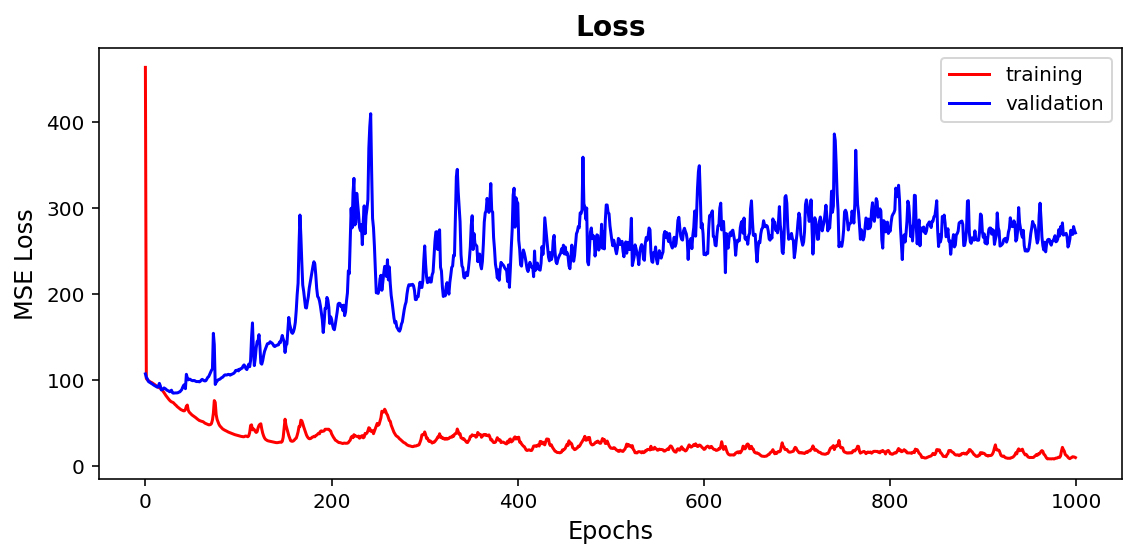

<Figure size 432x288 with 0 Axes>

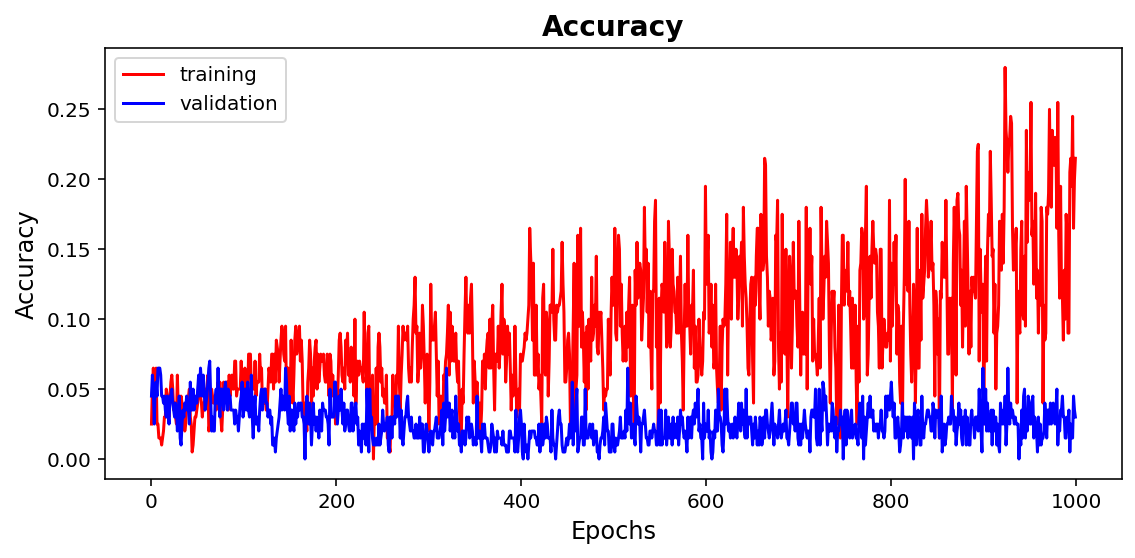

<Figure size 432x288 with 0 Axes>

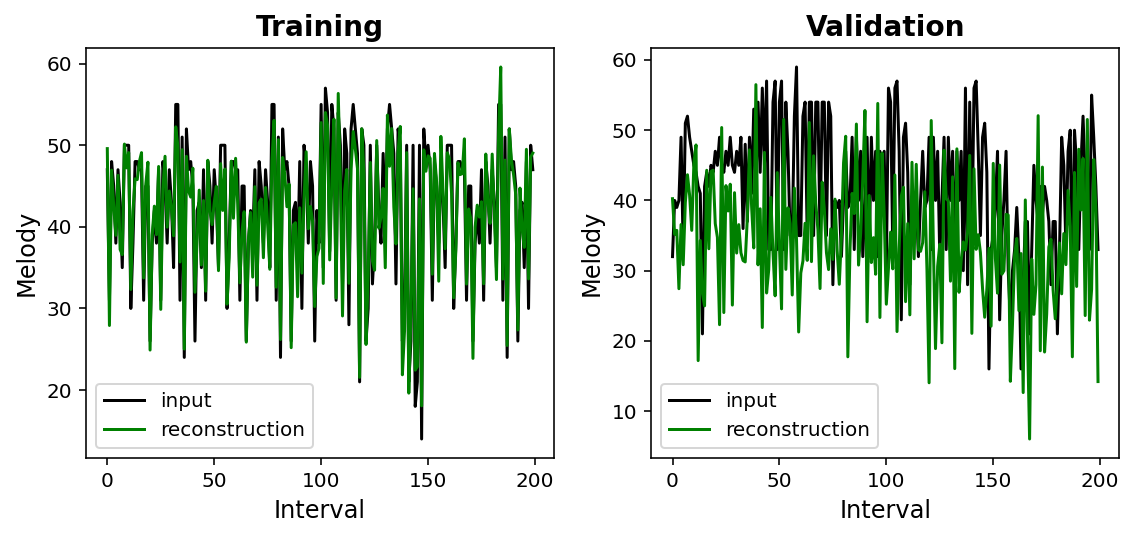

<Figure size 432x288 with 0 Axes>

In [30]:
vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/ae_loss.png', ylabel='MSE Loss')
vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/ae_MSE_acc.png', ylabel='Accuracy', title='Accuracy')
_ = vis.plot_train_val_sample(model_melody, X_train_melody[0], X_val_melody[0], './figures/ae_MSE_sample.png')